In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [49]:
# df = pd.read_csv(r'Diabetes Dataset/User_Oriented_Dataset.csv')
df = pd.read_csv(r'Diabetes Dataset/Diabetes_and_LifeStyle_Dataset.csv')

df.drop(columns=['systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total',
                 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides',
                 'glucose_fasting', 'glucose_postprandial', 'insulin_level', 
                 'hba1c', 'diagnosed_diabetes'])
df.loc[(df['diabetes_stage'] == 'Type 1') | (df['diabetes_stage'] == 'Type 2') | (df['diabetes_stage'] == 'Gestational'), 'diabetes_stage'] = 'Diabetes'

df.head()

,Age,gender,ethnicity,education_level,income_level,employment_status,smoking_status,alcohol_consumption_per_week,physical_activity_minutes_per_week,diet_score,...,hdl_cholesterol,ldl_cholesterol,triglycerides,glucose_fasting,glucose_postprandial,insulin_level,hba1c,diabetes_risk_score,diabetes_stage,diagnosed_diabetes
0,58,Male,Asian,Highschool,Lower-Middle,Employed,Never,0,215,5.7,...,41,160,145,136,236,6.36,8.18,29.6,Diabetes,1
1,52,Female,White,Highschool,Middle,Employed,Former,1,143,6.7,...,55,50,30,93,150,2.00,5.63,23.0,No Diabetes,0
2,60,Male,Hispanic,Highschool,Middle,Unemployed,Never,1,57,6.4,...,66,99,36,118,195,5.07,7.51,44.7,Diabetes,1
3,74,Female,Black,Highschool,Low,Retired,Never,0,49,3.4,...,50,79,140,139,253,5.28,9.03,38.2,Diabetes,1
4,46,Male,White,Graduate,Middle,Retired,Never,1,109,7.2,...,52,125,160,137,184,12.74,7.20,23.5,Diabetes,1


In [50]:
# User Oriented Model Features

features = ['Age', 'gender', 'ethnicity', 'smoking_status', \
        'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', \
        'sleep_hours_per_day', 'screen_time_hours_per_day', \
        'family_history_diabetes', 'hypertension_history', 'cardiovascular_history', \
        'bmi', 'waist_to_hip_ratio', 'diabetes_risk_score', 'diet_score']


# Select features and target variable
X = df[features]
y = df['diabetes_stage'] 

print(y.value_counts())

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)


numeric_features = [
    'Age',
    'alcohol_consumption_per_week',
    'physical_activity_minutes_per_week',
    'sleep_hours_per_day',
    'screen_time_hours_per_day',
    'bmi',
    'waist_to_hip_ratio'
]

categorical_features = [
    'gender',
    'ethnicity',
    'smoking_status',
    'family_history_diabetes',
    'hypertension_history',
    'cardiovascular_history'
]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

x_train_processed = preprocessor.fit_transform(x_train)
x_test_processed = preprocessor.transform(x_test)

encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

y_train_encoded = to_categorical(y_train_encoded)
y_test_encoded = to_categorical(y_test_encoded)

print(y_train_encoded.shape)
print(y_test_encoded.shape)

diabetes_stage
Diabetes        58547
Pre-Diabetes    31013
No Diabetes      7737
Name: count, dtype: int64
(82702, 3)
(14595, 3)


In [51]:
# Creating the Model

classes = ['No Diabetes', 'Pre Diabetes', 'Diabetes']

def build_patient_model():
    model = models.Sequential([
        # Input layer
        layers.Dense(64, activation='relu', input_shape=(x_train_processed.shape[1],)),
        # Output layer
        layers.Dense(3, activation='softmax')
    ])
    return model

# Initialize Patient-side Model
patient_model = build_patient_model()

patient_model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Implement Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Train the model
history = patient_model.fit(
    x_train_processed, y_train_encoded,
    epochs=50,
    verbose=1,
    validation_data=(x_test_processed, y_test_encoded),
    callbacks=[early_stopping]
)


Epoch 1/50


c:\Users\Sydney\Tensorflow\Keras-Diabetes\.venv\Lib\site-packages\keras\src\layers\core\dense.py:106: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2585/2585 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - accuracy: 0.5988 - loss: 0.8368 - val_accuracy: 0.5979 - val_loss: 0.8277
Epoch 2/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 3s 977us/step - accuracy: 0.6024 - loss: 0.8269 - val_accuracy: 0.6009 - val_loss: 0.8263
Epoch 3/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 3s 964us/step - accuracy: 0.6042 - loss: 0.8256 - val_accuracy: 0.6020 - val_loss: 0.8271
Epoch 4/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 2s 938us/step - accuracy: 0.6041 - loss: 0.8253 - val_accuracy: 0.5999 - val_loss: 0.8255
Epoch 5/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 2s 952us/step - accuracy: 0.6061 - loss: 0.8246 - val_accuracy: 0.6018 - val_loss: 0.8267
Epoch 6/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 2s 948us/step - accuracy: 0.6046 - loss: 0.8241 - val_accuracy: 0.5998 - val_loss: 0.8268
Epoch 7/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 3s 967us/step - accuracy: 0.6041 - loss: 0.8236 - val_accuracy: 0.6019 - val_loss: 0.8268
Epoch 8/50
2585/2585 ━━━━━━━━━━━━━━━━━━━━ 3s 978us/step - accuracy: 0.6044 - loss: 0.8233

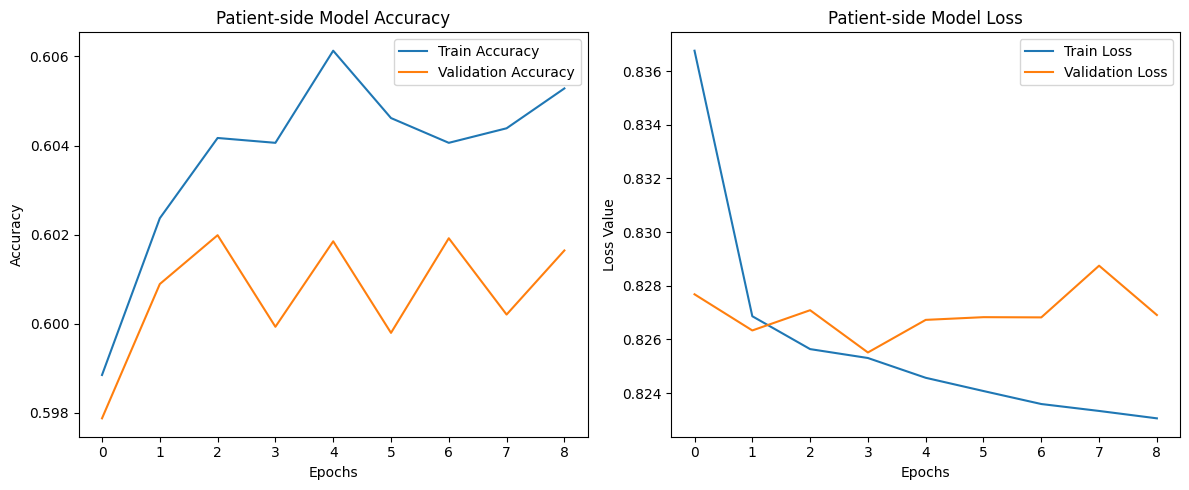

In [52]:
# Visualize Training History

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Patient-side Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Patient-side Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss Value')
plt.legend()
plt.tight_layout()
plt.show()